In [1]:
import numpy as np
import pandas as pd 
import pickle
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import nn_utils as nu
import data_utils as du
import data_augment as da
import cv_transf  as cvt

In [2]:
def get_track_data(training_path, track):
    track_path = os.path.join(data_training, track)
    data_sim_curves  = os.path.join(track_path, 'training.curves/')
    data_sim_recover = os.path.join(track_path, 'training.recover/')
    data_sim_center  = os.path.join(track_path, 'training.centered/')
    df_sim_curves    = du.reformat_csv(data_sim_curves,  header=False)
    df_sim_recover   = du.reformat_csv(data_sim_recover, header=False)
    df_sim_center    = du.reformat_csv(data_sim_center,  header=False)
    df_sim_comb      = pd.concat([df_sim_center, df_sim_recover, df_sim_curves], axis=0)
    print('Track: {}, Center: {}, Curves: {}, Recover: {}, Total: {}'.format(
        track, len(df_sim_center), len(df_sim_curves), len(df_sim_recover), len(df_sim_comb) )
    )
    return df_sim_comb

data_udacity     = 'data/udacity/'
data_training    = 'data/training/'
df_sim_track1    = get_track_data(data_training, 'track1')
df_sim_track2    = get_track_data(data_training, 'track2')
df_sim_comb      = pd.concat([df_sim_track1, df_sim_track2], axis=0)
df_drive_sim     = df_sim_comb.sample(frac=1.0).reset_index(drop=True)
df_drive_udacity = du.reformat_csv(data_udacity, header=True)
print("Training Simulator Total: {}".format(len(df_drive_sim)) )
print("Udacity Num Examples: {}".format(len(df_drive_udacity)) )
df_drive_sim.head()

Track: track1, Center: 3066, Curves: 3256, Recover: 1417, Total: 7739
Track: track2, Center: 4645, Curves: 2108, Recover: 1094, Total: 7847
Training Simulator Total: 15586
Udacity Num Examples: 8036


,center,left,right,steering,throttle,brake,speed
0,data/training/track2/training.centered/IMG/cen...,data/training/track2/training.centered/IMG/lef...,data/training/track2/training.centered/IMG/rig...,0.030218,0.0,0.0,0.531036
1,data/training/track2/training.centered/IMG/cen...,data/training/track2/training.centered/IMG/lef...,data/training/track2/training.centered/IMG/rig...,0.289062,0.0,0.0,8.741075
2,data/training/track1/training.curves/IMG/cente...,data/training/track1/training.curves/IMG/left_...,data/training/track1/training.curves/IMG/right...,-0.228700,0.0,0.0,9.823955
3,data/training/track1/training.recover/IMG/cent...,data/training/track1/training.recover/IMG/left...,data/training/track1/training.recover/IMG/righ...,0.055830,0.0,0.0,4.971726
4,data/training/track2/training.centered/IMG/cen...,data/training/track2/training.centered/IMG/lef...,data/training/track2/training.centered/IMG/rig...,-0.417895,0.0,0.0,17.659960


Image Dimensions: (160, 320, 3)


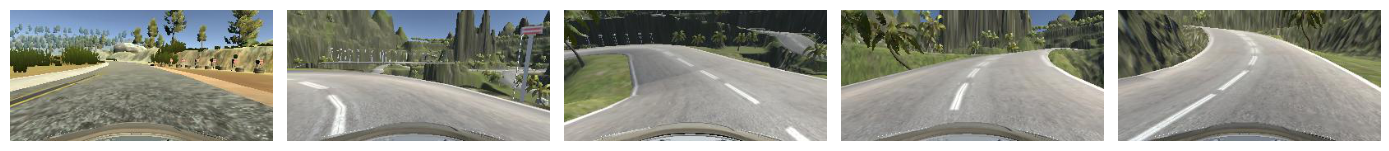

In [3]:
def set_axi_opts(axi, **kwargs):
    axi.grid(False)
    axi.get_yaxis().set_visible(False)
    axi.get_xaxis().set_ticks([])
    params = {'fontweight':'bold', 'fontstyle':'italic', 'fontsize': 10}
    if 'title'  in kwargs: axi.set_title(kwargs['title'], **params )
    if 'xlabel' in kwargs: axi.set_xlabel(kwargs['xlabel'])

def get_image(frame, sample_idx, col='center'):
    ds_sample  = frame.ix[sample_idx]
    img_sample = ds_sample[col].strip()
    img_data = mpimg.imread(img_sample)
    return img_data
  
# sample of center images 
fig, ax = plt.subplots(1, 5, figsize=(14,16))
axes = ax.flatten()
rand_idxs = np.random.randint(0, len(df_drive_sim),len(axes))
image_dim = get_image(df_drive_sim, rand_idxs[0]).shape
print("Image Dimensions: {}".format(image_dim))
for axi, sample_idx in zip(axes, rand_idxs):
    axi.imshow(get_image(df_drive_sim, sample_idx))
    set_axi_opts(axi)
plt.tight_layout()
fig.savefig('./images/center_camera_angles.png', transparent=False, bbox_inches='tight')

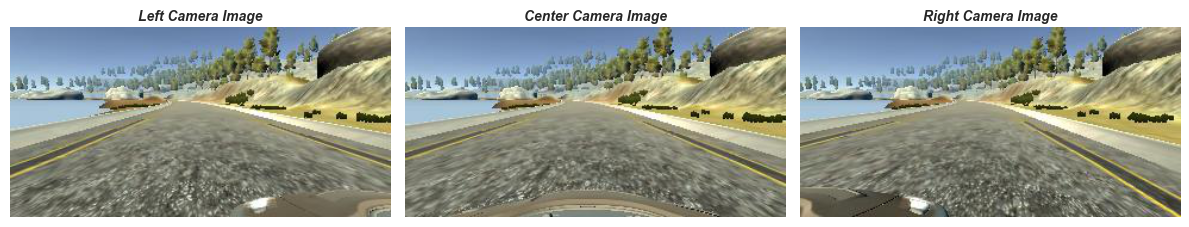

In [12]:
# sample snapshot of left, center, right instance
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,6))
sample_idx = np.random.randint(0, len(df_drive_sim), 1)[0]
titles = ['Left Camera Image', 'Center Camera Image', 'Right Camera Image']
ax1.imshow(get_image(df_drive_sim, sample_idx, col='left'))
ax2.imshow(get_image(df_drive_sim, sample_idx, col='center'))
ax3.imshow(get_image(df_drive_sim, sample_idx, col='right'))
_ = [set_axi_opts(axi, **{'title': title}) for axi,title in zip([ax1,ax2,ax3], titles)]
plt.tight_layout()
fig.savefig('./images/camera_angles.png', transparent=False, bbox_inches='tight')

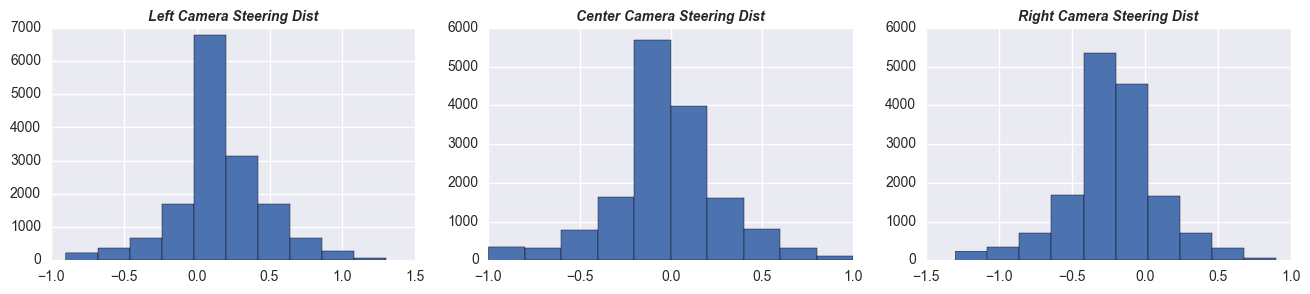

In [13]:
# plot distribution of steering angles w/small lateral shifts
def plot_steering_dist(df_dist):
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,3))
    df_dist['left_steering'].hist(ax=ax1)
    df_dist['steering'].hist(ax=ax2)
    df_dist['right_steering'].hist(ax=ax3)
    params = {'fontweight':'bold', 'fontstyle':'italic', 'fontsize': 10}
    titles = ['Left Camera Steering Dist', 'Center Camera Steering Dist', 'Right Camera Steering Dist']
    [axi.set_title(title, **params) for axi, title in zip((ax1,ax2,ax3),titles)]
    fig.savefig('./images/steering_distributions.png', transparent=False, bbox_inches='tight')
# csv produces float format for steering angles correctly    
df_sim_shift = du.lateral_shift(df_drive_sim)
_ = plot_steering_dist(df_sim_shift)

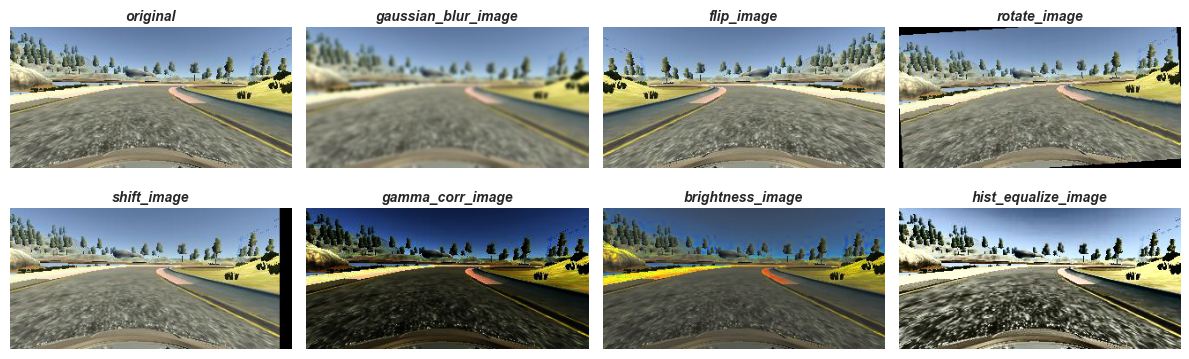

In [14]:
fig, ax = plt.subplots(2,4, figsize=(12,4))
df_center = df_sim_shift[df_sim_shift.steering == 0.0].reset_index(drop=True)
rand_idx  = np.random.randint(len(df_center))
fname, steer = df_center.ix[rand_idx].center, df_center.ix[rand_idx].steering

samples = da.aug_sample(fname, steer)
for axi, (data, steer_aug, title) in zip(ax.flatten(), samples):
    axi.imshow(mpimg.imread(data))
    set_axi_opts(axi, **{'title': title})
plt.tight_layout()
fig.savefig('./images/augmentation.png', transparent=False, bbox_inches='tight')